#  Entregable 1 - Aprendizaje Automático II


***<p style="text-align:center;">Regresión Logística (Clasificación) y Backpropagation</p>***

En este cuaderno vamos a implementar un modelo lineal con regresión logística y entrenarlo para clasificar datos bi-clase.

Usaremos el `Breast cancer wisconsin (diagnostic) dataset`de `Sklearn` descrito en el Anexo del Entregable 1, adjunto con esta práctica.

### Normas de Entrega

1. El formato de entrega será en una carpeta comprimida con nombre: {Iniciales de Nombre y Apellidos}_E1.zip, en Aula Virtual en la fecha señalada en la plataforma y comunicada en clase previamente.
    * Por ejemplo: Iván Ramírez Díaz ==> `IRD_E1.zip`
2. El contenido de dicha carpeta será:
    * Obligatorio: Notebook relleno del Entregable 1.
    * Opcional: Memoria explicativa (pdf), en caso de necesitar dar alguna explicación.
3. Antes de la entrega, se debe comprobar que el código completo funciona.
4. La entrega es individual.

### Evaluación

La práctica entregable tiene un peso global de 1/4 puntos (los 4 entregables son el 10% de la nota final).

La práctica entregable se calificará sobre 10 puntos. Las puntuaciones son las siguientes:

- **[Ejercicio 1]** Pregunta teórica (1 punto)
- **[Ejercicio 2]** Implementación del Backpropagation y evaluación (2 puntos)
- **[Ejercicio 3]** Modifica la función de pérdida a MSE, desarrolla el cálculo de los gradientes y compara el resultado con el ejercicio anterior (4 puntos)
- **[Ejercicio 4]** Implementar un `learning rate scheduler` haciendo uso del Cosine Annealing (1 punto)
- **[Ejercicio 5]** Incluir `momentum` en el SGD y comparar resultados (1 punto)
- **[Ejercicio 6]** Implementar el SGD con `minibatch` y comparar resultados (1 punto)


## Carga de los datos

In [51]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import matplotlib.pyplot as plt

data = load_breast_cancer()
X = data.data
y = data.target

## Creación del dataset

Necesitamos ahora crear los conjuntos de entrenamiento, validación y test. En este ejemplo, usaremos exclusivamente entrenamiento y test, por simplicidad. El particionado lo podemos realizar con funciones de apoyo de `sklearn`, como ya hemos visto anteriormente:

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 20% para test

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (455, 30)
X_test shape: (114, 30)
y_train shape: (455,)
y_test shape: (114,)


Ahora, podemos normalizar el dataset con el conjunto de entrenamiento:

In [53]:
# Normalización
mu = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mu) / std
X_test = (X_test - mu) / std

En resumen, el dataset que vamos a utilizar tiene las siguientes características:

1. Train set:
    * `X_train`$\in \mathbb{R}^{455,30}$ (tras normalizar)
    * `y_train`$\in \{0,1\}^{455}$
2. Test set:
    * `X_test`$\in \mathbb{R}^{114,30}$ (tras normalizar)
    * `y_test`$\in \{0,1\}^{114}$

## Definición del modelo

El modelo a utilizar se define como sigue para un ejemplo concreto ${\bf{x}} \in \mathbb{R}^{30}$:

$$
y = \text{Sigmoid}({\bf x}^T {\bf w} + b)
$$

donde $\text{Sigmoid}(x) = \frac{1}{1 + \exp{(-x)}}$. Por simplicidad, llamaremos $\sigma$ a la función Sigmoide, teniendo:

$$
y = \sigma({\bf x}^T {\bf w} + b).
$$

<!-- Si extendemos la definición a todo el conjunto de datos, tenemos:

$$
{\bf y} = \sigma({\bf X} {\bf w} +  b).
$$ -->

Recordemos que la función Sigmoide $\sigma(\cdot): \mathbb{R} \to [0,1]$ se evalúa punto a punto.


### Función de Pérdida

Definimos la función de pérdida para la regresión logística:

$$
\mathcal{L}(\hat{y}^{(i)}, y^{(i)}) = -y^{(i)}\log(\hat{y}^{(i)})-(1-y^{(i)})\log(1-\hat{y}^{(i)}),
$$

entonces, la función de costes (para todos los ejemplos) será:

$$
J(\theta) = \frac{1}{N} \sum_{i=1}^N -y^{(i)}\log(\hat{y}^{(i)})-(1-y^{(i)})\log(1-\hat{y}^{(i)}),
$$

donde $\theta = \{ {\bf w}, b\}$, es el conjunto de todos los parámetros del modelo.

Por comodidad, llamaremos $a$ a la predicción del modelo, y $z$ a la parte lineal (afín), tal que:

$$
a = \sigma(z) \quad \text{y} \quad z = {\bf x}^T {\bf w} + b
$$
obteniendo:

$$
\mathcal{L}(a^{(i)}, y^{(i)})  = -y^{(i)}\log(a^{(i)})-(1-y^{(i)})\log(1-a^{(i)})
$$
y
$$
J(\theta) = \frac{1}{N} \sum_{i=1}^N -y^{(i)}\log(a^{(i)})-(1-y^{(i)})\log(1-a^{(i)})
$$

respectivamente.

#### Derivación
Puesto que queremos obtener los parámetros óptimos que minimizan esta energía, definimos el problema de optimización como:

$$
\theta^* = \arg \min_{\theta} J(\theta).
$$

Para ello, usaremos un descenso de gradiente cuyo esquema iterativo se define como:

$$
{\theta}^{i+1} = {\theta}^{i} - \text{lr} \nabla_{\theta^i} J.
$$

Ahora, el gradiente se define como la derivada de la función de costes con respecto a los parámetros:

$$
\nabla_{\theta} J = \frac{\partial J}{\partial {\theta}}.
$$

En concreto, para nuestro modelo lineal con regresión logística, tenemos:

$$
J(\theta)=  \frac{1}{N} \sum_{i=1}^N -y^{(i)}\log(\sigma({\bf x^{(i)}}^T {\bf w} + b))-(1-y^{(i)})\log(1-\sigma({\bf x^{(i)}}^T {\bf w} + b)).
$$

o lo que es lo mismo:

$$
J(\theta)=  \frac{1}{N} \sum_{i=1}^N -y^{(i)}\log(a^{(i)})-(1-y^{(i)})\log(1-a^{(i)}).
$$

Si nos fijamos, el gradiente de la función de coste es lineal con respecto a los ejemplos, es decir, podemos calcularlo para cada uno de ellos por separado y luego agregarlos:

$$
\nabla_{\theta} J   = \frac{1}{N} \sum_{i=1}^N \nabla_{\theta} \mathcal{L}(a^{(i)}, y^{(i)})
$$

por lo que podemos centrarnos en obtener las derivadas de la función de pérdidas. 



En este ejemplo, tenemos 2 conjuntos de parámetros: ${\bf{W}}$ y ${\bf{b}}$, por lo que necesitaremos calcular:

1. $\frac{\partial \mathcal{L}}{\partial  {\bf w}} $
2. $\frac{\partial \mathcal{L}}{\partial  {\bf b}} $

## Cálculo de $\frac{\partial \mathcal{L}}{\partial  {\bf w}} $

Aplicando la regla de la cadena, tenemos que:
$$
\frac{\partial \mathcal{L}}{\partial  {\bf w}} = \frac{\partial \mathcal{L}}{\partial  { a^{(i)}}} \frac{\partial  {a^{(i)}}}{\partial z^{(i)}} \frac{\partial z^{(i)}}{\partial {\bf w}}
$$

vamos a analizar cada uno de los términos por separado:

#### 1. Derivada de $\frac{\partial \mathcal{L}}{\partial  { a^{(i)}}}$:

Supongamos que estamos usando la función de pérdida logarítmica para regresión logística, que es la entropía cruzada. La función de pérdida para un solo ejemplo es:

$$
\mathcal{L}  = -y^{(i)}\log(a^{(i)})-(1-y^{(i)})\log(1-a^{(i)})
$$

La derivada de $\mathcal{L}$ con respecto a $ a^{(i)} $ es:

$$
\frac{\partial \mathcal{L}}{\partial  a^{(i)}} = -\frac{y^{(i)}}{a^{(i)}} + \frac{1 - y^{(i)}}{1 - a^{(i)}}
$$

#### 2. Derivada de $\frac{\partial  a^{(i)}}{\partial z^{(i)}}$:

En la regresión logística, la activación $ a^{(i)} $ es el resultado de aplicar la función sigmoide a $ z^{(i)} $:

$$
a^{(i)} = \sigma(z^{(i)}) = \frac{1}{1 + e^{-z^{(i)}}}
$$

Es fácil demostrar que la derivada de la función sigmoide $\frac{\partial \sigma(x)}{\partial {x}} =\sigma(x)^{'}=\sigma(x) (1- \sigma(x))$. Por lo que la derivada de $ a^{(i)} $ con respecto a $ z^{(i)} $ es:

$$
\frac{\partial a^{(i)}}{\partial z^{(i)}} = a^{(i)}(1 - a^{(i)})
$$

#### 3. Derivada de $\frac{\partial z^{(i)}}{\partial {\bf w}}$:

Tenemos que  $z^{(i)} = {\bf x^{(i)}}^T {\bf w} + b$, cuya derivada con respecto a los pesos ${\bf w}$ es simplemente el vector de características ${\bf x}^{(i)}$:

$$
\frac{\partial z^{(i)}}{\partial {\bf w}} = {\bf x}^{(i)}
$$

#### 4. Combinar todas las derivadas:

Ahora, podemos combinar las derivadas calculadas:

$$
\frac{\partial \mathcal{L}}{\partial {\bf w}} = \frac{\partial \mathcal{L}}{\partial a^{(i)}} \cdot \frac{\partial a^{(i)}}{\partial z^{(i)}} \cdot \frac{\partial z^{(i)}}{\partial {\bf w}}
$$






## Cálculo de $\frac{\partial \mathcal{L}}{\partial  {\bf b}} $

# <span style="color:red">Ejercicio 1</span>
Ahora, haz lo mismo para determinar la expresión, detallando las derivadas parciales.

<span style="color:red">######################### Completar #########################</span>

Supongamos que estamos usando la función de pérdida logarítmica para regresión logística, que es la entropía cruzada. La función de pérdida para un solo ejemplo es:

$$
\mathcal{L}  = -y^{(i)}\log(a^{(i)})-(1-y^{(i)})\log(1-a^{(i)})
$$

1. Aplicamos la regla de la cadena

$\frac{\partial \mathcal{L}}{\partial  {\bf b}}  = \frac{\partial \mathcal{L}}{a^{(i)}} . \frac{\partial a^{(i)}}{\partial z^{(i)}} . \frac{\partial z^{(i)}}{\partial b}$

2. Derivamos el primer factor $\frac{\partial \mathcal{L}}{a^{(i)}}$

$\frac{\partial \mathcal{L}}{\partial a^{(i)}}
= -\,y^{(i)}\frac{1}{a^{(i)}}
- (1 - y^{(i)})\left(-\frac{1}{1 - a^{(i)}}\right)
= -\frac{y^{(i)}}{a^{(i)}} + \frac{1 - y^{(i)}}{1 - a^{(i)}}.$

3. Derivamos el segundo factor $\frac{\partial a^{(i)}}{\partial z^{(i)}}$

Sabiendo que la derivada de la función sigmoide es:
$\sigma'(z) = \sigma(z)\big(1 - \sigma(z)\big).$

Entonces:
$\frac{\partial a^{(i)}}{\partial z^{(i)}} = a^{(i)}\big(1 - a^{(i)}\big).$


4. Derivamos el tercer factor $\frac{\partial z^{(i)}}{\partial b}$

Recordamos: $z^{(i)} = \mathbf{x}^{(i)T}\mathbf{w} + b,$

A si que: $\frac{\partial z^{(i)}}{\partial b} = 1.$

5. Juntamos todas las derivadas parciales que hemos calculado y simplificamos

$\frac{\partial \mathcal{L}}{\partial b}
= \Big(-\frac{y^{(i)}}{a^{(i)}} + \frac{1 - y^{(i)}}{1 - a^{(i)}}\Big)
\cdot a^{(i)}\big(1 - a^{(i)}\big) \cdot 1.
$

Despues de simplificar nos queda: $\frac{\partial \mathcal{L}}{\partial b} = a^{(i)} - y^{(i)}$


<span style="color:red">######################## Fin Completar ########################</span>


# <span style="color:red">Ejercicio 2</span>

## Implementación - Backpropagation

Conocidos las derivadas parciales de los parámetros que necesitamos optimizar, podemos crear un modelo que implemente en algoritmo de retropropagación.

Se pide:
    
1. Implementar el método `forward` siguiendo el modelo de clasificación logística propuesto.
2. Implementar el método `backward` del algoritmo de retropropagación, según lo hemos visto en clase.

In [54]:
class LogisticBXE: # Logistic Binary Cross Entropy
    def __init__(self, w, b):
        self.w = w.astype(float)  # w debe tener shape (30, 1) para coincidir con las dimensiones de x
        self.b = float(b)  # b es un escalar
        
    def sigma(self, z):
        ######################### Completar #########################
        # Función sigmoide
        z = np.asarray(z, float)
        z = np.clip(z, -500.0, 500.0) #para evitar overflow
        return 1 / (1 + np.exp(-z))

    def forward(self, x, y):
        ######################### Completar #########################
        #asegramos shapes x (n,30) y (n, 1)
        x = np.asarray(x, float)
        if x.ndim == 1:
            x = x.reshape(1, -1)
        y = np.asarray(y, float).reshape(-1, 1)

        # Calculamos la pre-activación z 
        z = x @ self.w + self.b   # x tiene shape (30,1), w tiene shape (30,1) PRODRUCTO MATRICIAL!!! @
        self.z = z   # Guardamos la pre-activación

        ######################### Completar #########################
        # Calculamos la activación a
        a = self.sigma(z)# Calculamos la activación (output de la neurona)
        self.a = a  # Guardamos la activación

        ######################### Completar #########################
        # Calculamos la pérdida
        eps = 1e-12
        a = np.clip(a, eps, 1.0 - eps)
        loss = -np.mean(y * np.log(a) + (1-y)*np.log(1-a))   # Calculamos la pérdida para un solo ejemplo
        self.loss_value = loss  # Guardamos la pérdida
        return float(loss)   # Devolvemos la pérdida

    def backward(self, x, y):
        ######################### Completar #########################
        # Valores calculados en el forward
        z = self.z
        a = self.a
        n = x.shape[0]
        x = np.asarray(x, float).reshape(1, -1)
        y = np.asarray(y, float).reshape(1, -1)

        # Gradiente de la pérdida con respecto a la activación
        # dL_da = (-y/a) + ((1 - y)/(1 - a)) # Esto es la derivada de la pérdida
        
        # Derivada de la activación (sigmoide) con respecto a z
        #da_dz = a * (1 - a)
        
        # Gradiente de la pérdida con respecto a z (pre-activación)
        dL_dz = a - y

        dz_dw = x
        # Gradiente con respecto a los pesos w (x tiene shape (30, 1))
        dL_dw = x.T @ dL_dz  # No se promedia porque es un solo ejemplo

        dz_db = 1
        # Gradiente con respecto al bias (escalar)
        dL_db = -y + a  # No se promedia porque es un solo ejemplo
        
        # Devolvemos los gradientes en un diccionario
        grads = {"dw": dL_dw,  # dw tiene mismo shape que w
                 "db": dL_db}  # db tiene mismo shape que b
        
        return grads
        
    def loss(self, y_pred, y_true):
        ######################### Completar #########################
        # Calculamos la pérdida usando la entropía cruzada binaria para un solo ejemplo
        eps = 1e-12
        p = np.clip(np.asarray(y_pred, float).reshape(-1, 1), eps, 1 - eps)
        y = np.asarray(y_true, float).reshape(-1, 1)
        return float(-np.mean(y*np.log(p) + (1 - y)*np.log(1 - p)))

    def predict(self, x):
        ######################### Completar #########################
        # Predicción del modelo
        # x puede ser 1 ejemplo o varios
        # predict devuelve tantas predicciones como ejemplos haya en x
        x = np.asarray(x, float)
        if x.ndim == 1:
            x = x.reshape(1,-1)
        z = x @ self.w + self.b
        a = self.sigma(z)
        y_pred = a

        # la predicción debe ser umbralizada
        return np.uint8(y_pred > 0.5)  # Convertimos a 0 o 1 según el umbral de 0.5

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    def step(self, model, grads):
        ######################### Completar #########################
        # Implementamos el descenso de gradiente estocástico
        # Actualizamos los pesos y el bias
        dw = grads["dw"]
        db = grads["db"]
        model.w = model.w - self.lr * dw
        model.b = model.b - self.lr * db

Ahora ya tenemos todos los elementos para poder implementar el entrenamiento (descenso de gradiente) para nuestro modelo. Recordemos que el *pipeline* a seguir es de este estilo:

```mermaid
    flowchart LR
        X[x] --> M["Modelo"] 
        M -- y --> P(Función de Pérdida)
        P -- Loss --> G(Cálculo del Gradiente)
        G -->|Actualización de Parámetros| M
        M --> Convergencia{Convergencia?}
        Convergencia -- Sí --> Salida[Modelo Entrenado]
        Convergencia -- No --> M

```

Iteración 196/200 - Pérdida: 0.0347

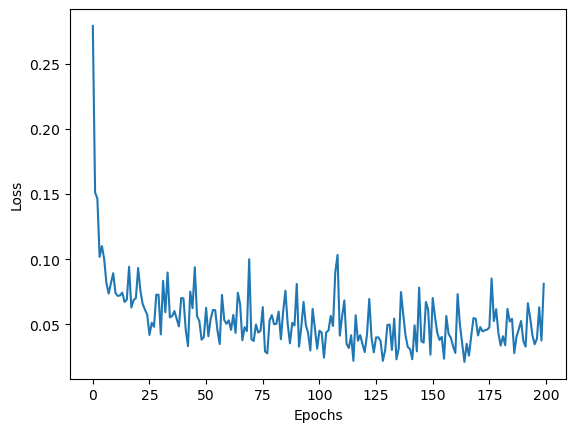

In [55]:
np.random.seed(1)

######################### Completar #########################
# Creación del modelo
# Inicialización de los pesos y el sesgo
w = 0.5*np.random.randn(30,1)
b = 0.1

# Instanciamos el modelo
modelo = LogisticBXE(w=w, b=b)

# Instanciamos el optimizador
lr = 0.01
opt = SGD(lr = lr)

# Fijamos número de épocas y ejemplos de entrenamiento
n_epochs = 200
n_samples = X_train.shape[0]

losses = []

# Iteramos en número de épocas y ejemplos de entrenamiento (SGD puro)
for e in range(n_epochs):
    loss_epoch = []
    for s in range(n_samples):
        # muestreamos 1 ejemplo del conjunto de entrenamiento
        rand_idx = np.random.randint(0, n_samples)
        x_sample, y_sample = X_train[rand_idx].reshape(1, -1),  y_train[rand_idx].reshape(1, 1)   # OJO CON LAS DIMENSIONES DE LA ENTRADA
        
        # forward
        loss = modelo.forward(x_sample, y_sample)
        # backward
        grads = modelo.backward(x_sample, y_sample)
        # optimizer (descenso)
        opt.step(modelo, grads)

        loss_epoch.append(loss)
    losses.append(np.mean(loss_epoch))
    if e % 5 == 0:
        print(f"\rIteración {e+1}/{n_epochs} - Pérdida: {losses[-1]:.4f}", end='', flush=True)

# Pintar la pérdida
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Realizar predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test)

Reportamos los resultados y la matriz de confusión:

Precisión del modelo: 0.9737


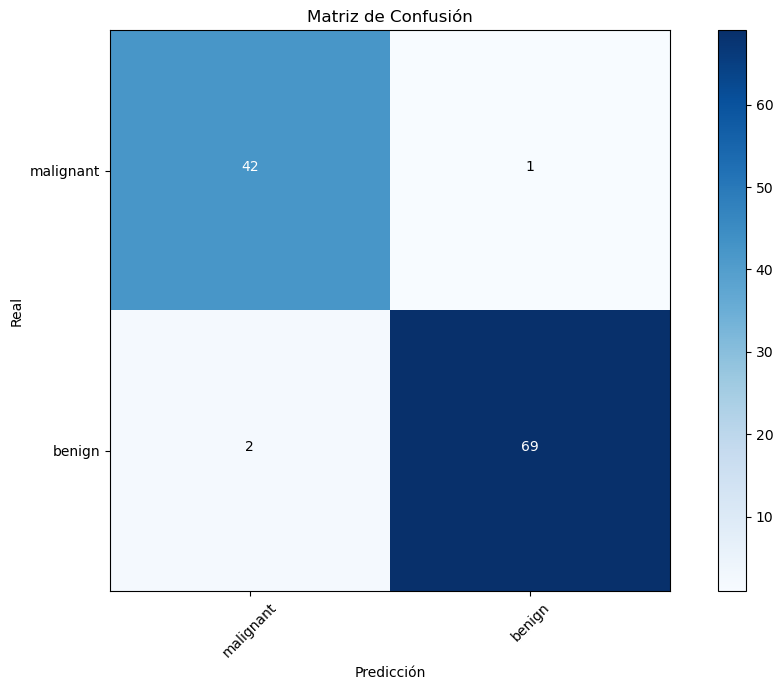

In [56]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.4f}")

# Imprimir la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión usando matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()

classes = data.target_names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

# <span style="color:red">Ejercicio 3</span>

Modifica la función de pérdida a MSE, desarrolla el cálculo de los gradientes y compara el resultado con el ejercicio anterior.


### Cálculo de gradientes con MSE (completar)

### Función de Pérdida

...


In [57]:
######################### Completar #########################
# Puedes llamar a la clase `LogisticMSE`
class LogisticMSE:
    def __init__(self, w, b):
        self.w = w.astype(float)
        self.b = float(b)

    def sigma(self, z):
        z = np.clip(z, -500, 500) #sigmoide estable
        return 1 / (1 + np.exp(-z))

    def forward(self, x, y):
        x = np.asarray(x, float)
        if x.ndim == 1:
            x = x.reshape(1, -1)
        y = np.asarray(y, float).reshape(-1, 1)

        #preactivacion
        z = x @ self.w + self.b
        self.z = z

        #activacion
        a = self.sigma(z)
        self.a = a

        #calculamos la pérdida
        loss = 0.5 * np.mean((a - y)**2)
        self.loss_value = loss

        return float(loss)


    def backward(self, x, y):
        x = np.asarray(x, float)
        y = np.asarray(y, float).reshape(-1, 1)
        N = x.shape[0]

        dL_dz = (self.a - y) * self.a * (1 - self.a)

        dw = (x.T @ dL_dz) /N
        db = float(np.mean(dL_dz))
        grad = {
            "dw": dw,
            "db" : db
        } #dicciionario
        return grad


    def predict(self, x):
        x = np.asarray(x, float)
        if x.ndim == 1:
            x = x.reshape(-1 , 1)
        z = x @ self.w + self.b
        a = 1.0 / (1.0 + np.exp(-np.clip(z, -500, 500)))
        y_pred = a
        return (a > 0.5).astype(np.uint8).reshape(-1)

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    def step(self, model, grads):
        ######################### Completar #########################
        # Implementamos el descenso de gradiente estocástico
        # Actualizamos los pesos y el bias
        dw = grads["dw"]
        db = grads["db"]
        model.w = model.w - self.lr * dw
        model.b = model.b - self.lr * db


Iteración 196/200 - Pérdida: 0.0067<class 'numpy.ndarray'> (114,)


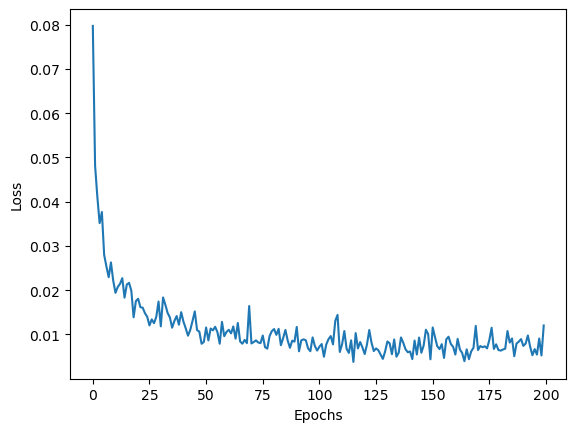

In [58]:
np.random.seed(1)

######################### Completar #########################
# Creación del modelo
# Inicialización de los pesos y el sesgo
w = 0.5*np.random.randn(30,1)
b = 0.1

# Instanciamos el modelo
modelo = LogisticMSE(w=w, b=b)

# Instanciamos el optimizador
lr = 0.01
opt = SGD(lr = lr)

# Fijamos número de épocas y ejemplos de entrenamiento
n_epochs = 200
n_samples = X_train.shape[0]

losses = []

# Iteramos en número de épocas y ejemplos de entrenamiento (SGD puro)
for e in range(n_epochs):
    loss_epoch = []
    for s in range(n_samples):
        # muestreamos 1 ejemplo del conjunto de entrenamiento
        rand_idx = np.random.randint(0, n_samples)
        x_sample, y_sample = X_train[rand_idx].reshape(1, -1),  y_train[rand_idx].reshape(1, 1)   # OJO CON LAS DIMENSIONES DE LA ENTRADA

        # forward
        loss = modelo.forward(x_sample, y_sample)
        # backward
        grads = modelo.backward(x_sample, y_sample)
        # optimizer (descenso)
        opt.step(modelo, grads)

        loss_epoch.append(loss)
    losses.append(np.mean(loss_epoch))
    if e % 5 == 0:
        print(f"\rIteración {e+1}/{n_epochs} - Pérdida: {losses[-1]:.4f}", end='', flush=True)

# Pintar la pérdida
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Realizar predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test)
print(type(y_pred), y_pred.shape)

Precisión del modelo: 0.9825


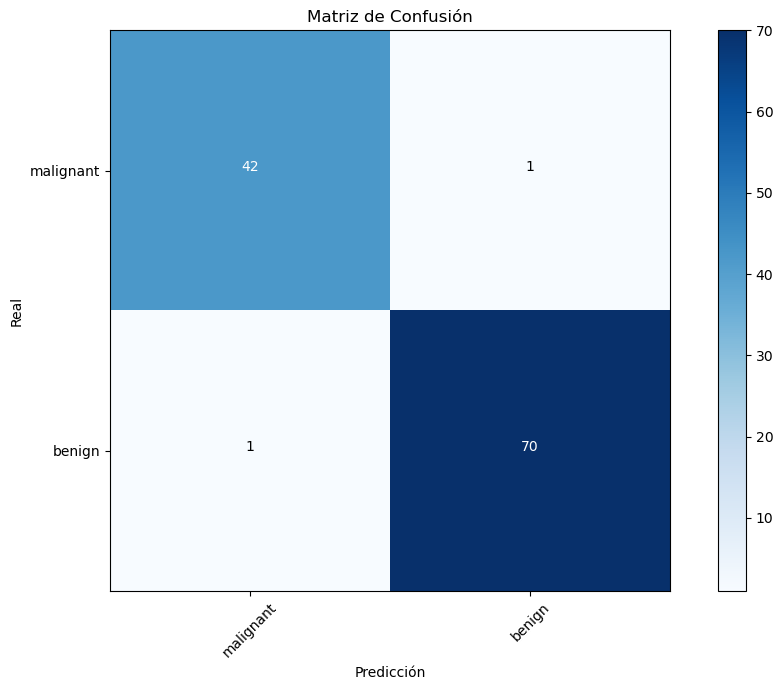

In [59]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.4f}")

# Imprimir la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión usando matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()

classes = data.target_names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

# <span style="color:red">Ejercicio 4</span>

Implementar un `learning rate scheduler` haciendo uso del Cosine Annealing

`fórmula del Cosine Annealing Scheduler`
$$
\eta_t = \eta_{\min} + \frac{1}{2} \left( \eta_{\max} - \eta_{\min} \right)
\left( 1 + \cos\left( \frac{\pi t}{T_{\max}} \right) \right)
$$


In [60]:
######################### Completar #########################
# Usa dos periodos del coseno. Cada ciclo debe corresponder a una época. Pinta el learning rate scheduler resultante durante dos épocas.
import math
class CosineAnnealingScheduler:
    def __init__(self, optimizer, lr_max, lr_min, T_max):
        self.optimizer = optimizer #instancia del optimizador
        self.lr_max = lr_max #lr inicial (maxima)
        self.lr_min = lr_min #lr minimo
        self.T_max = T_max #numero total de epocas del ciclo
        self.epoch = 0

    def step(self):
        #actualiza el lr segun la formula de cosine annealing
        lr = self.lr_min + 0.5 * (self.lr_max - self.lr_min) * (1 + math.cos(math.pi * self.epoch / self.T_max))

        #actualizamos el lr del optimizador
        self.optimizer.lr = lr
        self.epoch += 1

        return lr


Época 1/200 - Pérdida: 0.0080 - lr: 0.10000
Época 11/200 - Pérdida: 0.0047 - lr: 0.09939
Época 21/200 - Pérdida: 0.0085 - lr: 0.09758
Época 31/200 - Pérdida: 0.0048 - lr: 0.09460
Época 41/200 - Pérdida: 0.0076 - lr: 0.09055
Época 51/200 - Pérdida: 0.0055 - lr: 0.08550
Época 61/200 - Pérdida: 0.0034 - lr: 0.07960
Época 71/200 - Pérdida: 0.0050 - lr: 0.07297
Época 81/200 - Pérdida: 0.0045 - lr: 0.06580
Época 91/200 - Pérdida: 0.0030 - lr: 0.05824
Época 101/200 - Pérdida: 0.0080 - lr: 0.05050
Época 111/200 - Pérdida: 0.0066 - lr: 0.04276
Época 121/200 - Pérdida: 0.0034 - lr: 0.03520
Época 131/200 - Pérdida: 0.0032 - lr: 0.02803
Época 141/200 - Pérdida: 0.0051 - lr: 0.02140
Época 151/200 - Pérdida: 0.0045 - lr: 0.01550
Época 161/200 - Pérdida: 0.0039 - lr: 0.01045
Época 171/200 - Pérdida: 0.0079 - lr: 0.00640
Época 181/200 - Pérdida: 0.0025 - lr: 0.00342
Época 191/200 - Pérdida: 0.0030 - lr: 0.00161


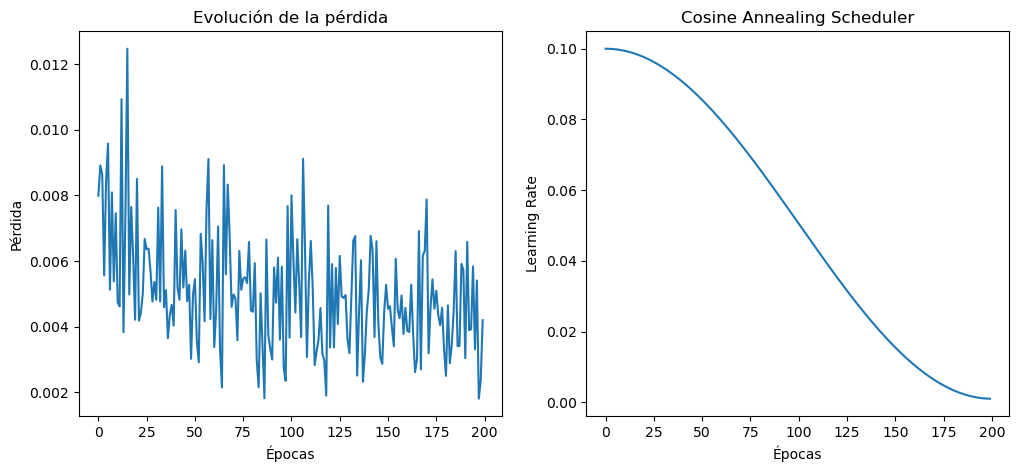

In [61]:
# Instanciamos el optimizador y el scheduler
lr_max = 0.1
lr_min = 0.001
opt = SGD(lr=lr_max)
scheduler = CosineAnnealingScheduler(opt, lr_max=lr_max, lr_min=lr_min, T_max=200)

losses = []
lrs = []  # para guardar la evolución del learning rate

for e in range(n_epochs):
    loss_epoch = []
    for s in range(n_samples):
        rand_idx = np.random.randint(0, n_samples)
        x_sample = X_train[rand_idx].reshape(1, -1)
        y_sample = y_train[rand_idx].reshape(1, 1)

        loss = modelo.forward(x_sample, y_sample)
        grads = modelo.backward(x_sample, y_sample)
        opt.step(modelo, grads)

        loss_epoch.append(loss)

    # actualizamos el learning rate tras cada época
    current_lr = scheduler.step()
    lrs.append(current_lr)

    losses.append(np.mean(loss_epoch))
    if e % 10 == 0:
        print(f"Época {e+1}/{n_epochs} - Pérdida: {losses[-1]:.4f} - lr: {current_lr:.5f}")

# Graficar pérdidas y LR
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses)
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Evolución de la pérdida")

plt.subplot(1,2,2)
plt.plot(lrs)
plt.xlabel("Épocas")
plt.ylabel("Learning Rate")
plt.title("Cosine Annealing Scheduler")
plt.show()


# <span style="color:red">Ejercicio 5</span>

Modifica el código para incluir `momentum` en el SGD. Compara los resultados



$\begin{aligned}
\mathbf{m}_{t+1} &= \beta \, \mathbf{m}_t + (1 - \beta) \, \nabla_\phi L_t \\
\phi_{t+1} &= \phi_t - \alpha \, \mathbf{m}_{t+1}
\end{aligned}$



In [62]:
######################### Completar #########################
# Implementa el momentum en el SGD y compara el modelo logisticMSE con y sin momentum
class SGD:
    def __init__(self, lr=0.01, momentum = 0.0):
        self.lr = float(lr)
        self.momentum = float(momentum)
        #almacenamiento de la velocidad del momentum
        self.v_w = None
        self.v_b = 0.0

    def step(self, model, grads):
        dw = grads["dw"] #gradiente actual de los pesos
        db = grads["db"] #gradiente actual del bias

        if self.v_w is None:
            self.v_w = np.zeros_like(model.w)
            self.v_b = 0.0

        if self.momentum > 0.0: # se aplica momentum
            self.v_w = self.momentum * self.v_w + dw
            self.v_b = self.momentum * self.v_b + db

            model.w = model.w - self.lr * self.v_w
            model.b = model.b - self.lr * self.v_b
        else: # no se aplica momentum -> SGD
            model.w = model.w - self.lr * dw
            model. b = model.b - self.lr * db



In [63]:
def train_sgd(modelo, opt, X_train, y_train, n_epochs=200):
    n_samples = X_train.shape[0]
    losses = []
    for e in range(n_epochs):
        loss_epoch = []
        for _ in range(n_samples):
            i = np.random.randint(0, n_samples)
            x_s = X_train[i].reshape(1, -1)     # (1,30)
            y_s = y_train[i].reshape(1, 1)      # (1,1)
            loss = modelo.forward(x_s, y_s)
            grads = modelo.backward(x_s, y_s)
            opt.step(modelo, grads)
            loss_epoch.append(loss)
        losses.append(np.mean(loss_epoch))
    return losses


In [68]:
np.random.seed(1)
w0 = 0.01 * np.random.randn(30,1)
b0 = 0.0

# Modelo 1: sin momentum
modelo_nomom = LogisticMSE(w=w0.copy(), b=b0)
opt_nomom = SGD(lr=0.1, momentum=0.0)
losses_nomom = train_sgd(modelo_nomom, opt_nomom, X_train, y_train, n_epochs=200)
y_pred_nomom = modelo_nomom.predict(X_test)
acc_nomom = accuracy_score(y_test, y_pred_nomom)

# Modelo 2: con momentum
modelo_mom = LogisticMSE(w=w0.copy(), b=b0)
opt_mom = SGD(lr=0.1, momentum=0.9)   # tip: 0.8–0.95 suele ir bien
losses_mom = train_sgd(modelo_mom, opt_mom, X_train, y_train, n_epochs=200)
y_pred_mom = modelo_mom.predict(X_test)
acc_mom = accuracy_score(y_test, y_pred_mom)

print(f"Accuracy sin momentum : {acc_nomom:.4f}")
print(f"Accuracy con momentum : {acc_mom:.4f}")


Accuracy sin momentum : 0.9825
Accuracy con momentum : 0.9825


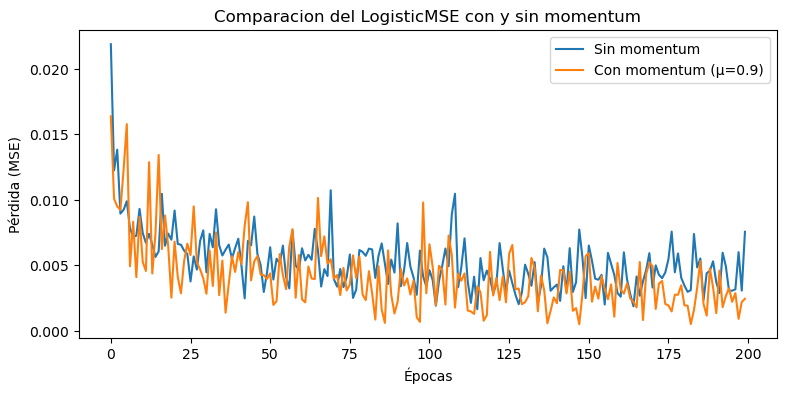

In [69]:
plt.figure(figsize=(9,4))
plt.plot(losses_nomom, label="Sin momentum")
plt.plot(losses_mom, label="Con momentum (μ=0.9)")
plt.xlabel("Épocas"); plt.ylabel("Pérdida (MSE)")
plt.title("Comparacion del LogisticMSE con y sin momentum")
plt.legend(); plt.show()


######################### Completar #########################
# ¿Qué diferencias encuentras?

La principal diferencia es que el modelo que usa moementum mantiene una perdida significativamente inferior al modelo que no lo usa.
Esto se debe a que el término del momenentum hace que se suavicen las oscilaciones y se acelera la conergencia.
Sin moemntum la pérdida desciende más lentamente y muestra más variaciones entre épocas.

# Vamos a cambiar el $Learning \space rate$ y vemos que pasa

In [74]:
np.random.seed(1)
w0 = 0.01 * np.random.randn(30,1)
b0 = 0.0

# Modelo 1: sin momentum
modelo_nomom = LogisticMSE(w=w0.copy(), b=b0)
opt_nomom = SGD(lr=0.5, momentum=0.0)
losses_nomom2 = train_sgd(modelo_nomom, opt_nomom, X_train, y_train, n_epochs=200)
y_pred_nomom = modelo_nomom.predict(X_test)
acc_nomom = accuracy_score(y_test, y_pred_nomom)

# Modelo 2: con momentum
modelo_mom = LogisticMSE(w=w0.copy(), b=b0)
opt_mom = SGD(lr=0.5, momentum=0.9)   # tip: 0.8–0.95 suele ir bien
losses_mom2 = train_sgd(modelo_mom, opt_mom, X_train, y_train, n_epochs=200)
y_pred_mom = modelo_mom.predict(X_test)
acc_mom = accuracy_score(y_test, y_pred_mom)

print(f"Accuracy sin momentum : {acc_nomom:.4f}")
print(f"Accuracy con momentum : {acc_mom:.4f}")


Accuracy sin momentum : 0.9825
Accuracy con momentum : 0.9912


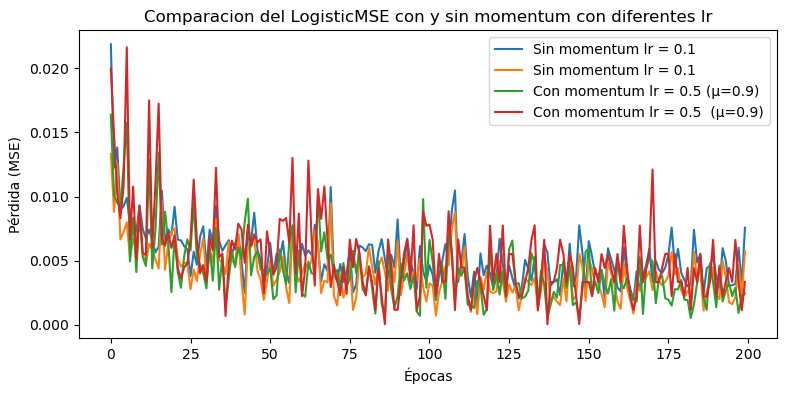

In [78]:
plt.figure(figsize=(9,4))
plt.plot(losses_nomom, label="Sin momentum lr = 0.1")
plt.plot(losses_nomom2, label="Sin momentum lr = 0.1")

plt.plot(losses_mom, label="Con momentum lr = 0.5 (μ=0.9)")
plt.plot(losses_mom2, label="Con momentum lr = 0.5  (μ=0.9)")

plt.xlabel("Épocas"); plt.ylabel("Pérdida (MSE)")
plt.title("Comparacion del LogisticMSE con y sin momentum con diferentes lr")
plt.legend(); plt.show()


Como podemos observar en el gráfico al cambiar el $lr$ el modelo termina convergiendo de todas formas y sigue una evolucion muy similar.

# <span style="color:red">Ejercicio 6</span>

Modifica el código para incluir entrenamiento con minibatch en el SGD. Compara los resultados

In [44]:
######################### Completar #########################
# Implementa el minibatch en el SGD y compara el modelo logisticMSE con y sin minibatch (batch de 32)
def train_sgd(modelo, opt, X_train, y_train, n_epochs = 200, batch_size = 1, seed = 1):
    rng = np.random.default_rng(seed)
    N = X_train.shape[0]
    losses = []

    for e in range(n_epochs):
        #barajamos los índices cada epoca
        idx = rng.permutation(N)
        loss_epoch = []

        #recorrer en bloques
        for start in range(0, N, batch_size):
            end = min(start+batch_size, N)
            b = idx[start:end]

            Xb = X_train[b]
            yb = y_train[b].reshape(-1,1)

            loss = modelo.forward(Xb, yb) #fordward en batch
            grads = modelo.backward(Xb, yb) #gradientes promediados en batch
            opt.step(modelo, grads)

            loss_epoch.append(loss)

        losses.append(float(np.mean(loss_epoch)))
    return losses


#Comprobamos el modelo LogisticMSE con y sin minibatch
np.random.seed(1)
w0= 0.01 * np.random.randn(30,1)
b0 = 0.0

# sin minibatch -> un sgd normal
modelo_sgd = LogisticMSE(w = w0.copy(), b = b0)
opt_sgd = SGD(lr = 0.05, momentum = 0.0)
losses_sgd = train_sgd(modelo_sgd, opt_sgd, X_train, y_train, n_epochs = 200, batch_size = 1, seed = 123)
y_pred_sgd = modelo_sgd.predict(X_test)
acc_sgd = accuracy_score(y_test, y_pred_sgd)

# con minibatch -> batch de 32
modelo_mb = LogisticMSE(w=w0.copy(), b = b0)
opt_mb = SGD(lr = 0.05, momentum = 0.0)
losses_mb = train_sgd(modelo_mb, opt_mb, X_train, y_train, n_epochs= 200, batch_size = 32, seed=123)
y_pred_mb = modelo_mb.predict(X_test)
acc_mb = accuracy_score(y_test, y_pred_mb)

print(f"Accuracy sin minibatch : {acc_sgd:.4f}")
print(f"Accuracy con minibatch : {acc_mb:.4f}")

SGD object: <class '__main__.SGD'>
Módulo: __main__
Firma __init__: (self, lr=0.01, momentum=0.0)
Accuracy sin minibatch : 0.9912
Accuracy con minibatch : 0.9912


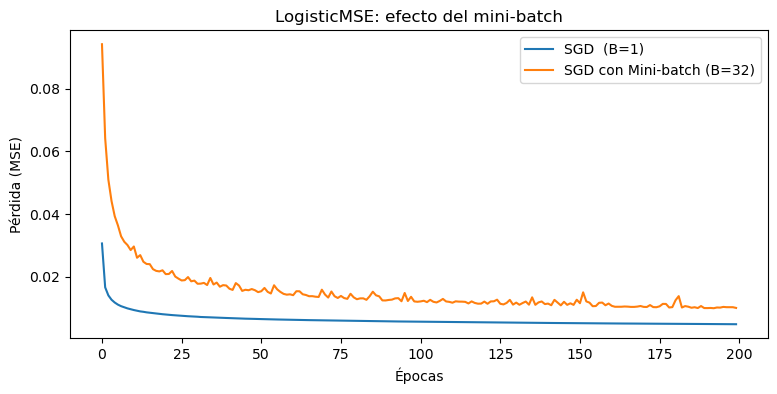

In [48]:
plt.figure(figsize=(9,4))
plt.plot(losses_sgd, label="SGD  (B=1)")
plt.plot(losses_mb,  label="SGD con Mini-batch (B=32)")
plt.xlabel("Épocas"); plt.ylabel("Pérdida (MSE)")
plt.title("LogisticMSE: efecto del mini-batch")
plt.legend()
plt.show()


######################### Completar #########################
# ¿Qué diferencias encuentras?
En el entrenamiento del modelo con minibatch (b = 32) observamos oscilaciones en la pérdida. Esto se debe a la variación de los gradientes entre los batches y a que hemos "barajado" los datos en cada época.

De todas formas, la tendencia es decreciente, a sí que el modelo está aprendiendo correctamente.

Pero en este caso, con este batch, épocas y learning rate concretos el SGD sin minibatches alcanza una pérdida inferior a la del SGD con minibatches